# Epileptic Seizure Recognition with Wavelet Transform

#### Nur Altıparmak
Epileptic seizure is a disease that affects a large number of people and it is caused by abnormal electrical activity in the brain [1]. Most seizures are very brief and rarely life threatening but critical seizures have to be recognized immediately.Also, according to studies[6], it is possible to control the attacks with early diagnosis.In addition Epileptic seizure patients require special treatments and continuous observation for the disease symptoms. Therefore several methods for epileptic seizure recognition have been developed in the past for early diagnosis. One of them is recognition with EEG signals. Even though EEG signals are a strong tool for epileptic seizure recognition, visual inspect for discriminating EEGs is a time consuming and high costly process [2].Therefore this project is aimed to make epileptic seizure detection using EEG signals that are transformed by wavelet transform, with machine learning and deep learning techniques.  

## Table of Content

[Problem](#problem)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling](#modeling)   
[Evaluation](#evaluation)   
[References](#references)   


## Problem <a class="anchor" id="problem"></a>

Epilepsy is a group of neurological disorders characterized by recurrent epileptic seizures.[3]This seizures can cause severe shaking attacks therefore in these seizures patients can hurt her/hisself very badly.Luckily epilepsy is a curable diasease that 70% of cases are controlable with early diagnosis and medication[4][5].Therefore in order to make an early diagnosis, many epilepsy diagnostic methods have been developed over time. One of them is diagnosis with the help of EEG signals.However the visual inspect process for discriminating EEGs is a time consuming and high costly process.Therefore the project is aimed to make epileptic seizure detection very quickly and accurately by using EEG signal of the brain data with machine learning and deep learning techniques.

## Data Understanding<a class="anchor" id="data_understanding"></a>

For this task,I will use Bonn University’s restructured EEG time series dataset that consists of 5 different target classes , 179 attributes and it contains 11500 samples.The classes 2, 3, 4, and 5 are subjects who did not have epileptic seizure. Only subjects in class 1 have epileptic seizure.I provied more details about dataset below.

![alt text](https://drive.google.com/uc?id=1nkOyWgqc1jc7LXD-aOfzOoA_cQa7eJ0p)

$$$$

![alt text](https://drive.google.com/uc?id=1UrYrwvOzx0w57axwOJL7FvJ16M-d2V8B)

This dataset is available on https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition

In [0]:
from google.colab import files
uploaded = files.upload() #choose data.csv file from provided files

Saving data.csv to data.csv


In [0]:
import pandas as pd
import numpy as np
df=pd.read_csv("data.csv")
df.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,...,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,-10,35,64,113,152,164,127,50,-47,-121,-138,-125,-101,-50,11,39,24,48,64,46,13,-19,-61,-96,-130,-132,-116,-115,-71,...,54,90,111,107,64,32,18,-25,-69,-65,-44,-33,-57,-88,-114,-130,-114,-83,-53,-79,-72,-85,-109,-98,-72,-65,-63,-11,10,8,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,...,27,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,-99,-94,-96,-104,-103,-92,-75,-69,-69,-53,-37,-14,-10,-39,-78,-102,-98,-80,-54,-40,-35,-39,-32,-13,7,34,41,33,6,...,-82,-107,-126,-124,-108,-84,-68,-61,-56,-63,-62,-33,1,28,45,37,48,62,80,66,23,-11,-39,-44,-42,-45,-48,-42,-6,29,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,-72,-68,-74,-80,-83,-73,-68,-61,-58,-59,-64,-79,-84,-97,-94,-84,-77,-75,-72,-68,-76,-76,-72,-67,-69,-69,-69,-67,-68,...,-69,-66,-74,-69,-61,-51,-45,-45,-49,-58,-64,-78,-80,-90,-87,-83,-78,-64,-38,-22,-29,-42,-51,-68,-71,-69,-69,-74,-74,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,-90,-103,-84,-43,-9,3,-21,-60,-96,-103,-75,-29,14,55,78,73,28,-13,-43,-68,-78,-75,-55,-41,-19,-20,-29,-36,-20,...,38,26,10,-4,-13,-8,0,10,19,29,57,63,45,7,-13,-23,-9,9,11,3,-1,-2,4,18,27,27,14,15,11,10,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [0]:
print("General info about colums,rows etc.")
df.info()
print("\nTarget variables value counts\n",df["y"].value_counts())

General info about colums,rows etc.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Columns: 180 entries, Unnamed: 0 to y
dtypes: int64(179), object(1)
memory usage: 15.8+ MB

Target variables value counts
 5    2300
4    2300
3    2300
2    2300
1    2300
Name: y, dtype: int64


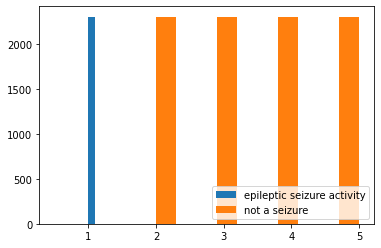

In [0]:
import matplotlib.pyplot as plt
def hist(df,plt):
  plt.hist(df[df["y"]==1]["y"],label="epileptic seizure activity")
  plt.hist(df[df["y"]!=1]["y"],label="not a seizure")
  plt.legend(loc='lower right')
  plt.show()

hist(df,plt)

All class have same amount of instances and dataset looks balance however i will transform target variable into seizure or not so dataset will no longer be balanced.

## Data Preparation<a class="anchor" id="data_preparation"></a>


In data preparation process, firstly i cleaned the data from unnecessary columns then I transformed the target variable into binary classes (1 for seizure, 0 for not seizure).Then I created new variables with some mathematical transformations that called Hurst exponent and Discrete wavelet transformation (do not worry, I will explain all these transformations below.). Then i normalize data.After i restructured the unbalanced data into more balanced data.Lastly I inspected whether feature selection improve accuracies.

######**Cleaning the data and transforming the target variable**

In [0]:
df.head(2) #just a quick look to data again. x1...x178 columns are a part of our time-series data (EEG Signals) but Unnamed: 0 column must be inspected.

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,...,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,-10,35,64,113,152,164,127,50,-47,-121,-138,-125,-101,-50,11,39,24,48,64,46,13,-19,-61,-96,-130,-132,-116,-115,-71,...,54,90,111,107,64,32,18,-25,-69,-65,-44,-33,-57,-88,-114,-130,-114,-83,-53,-79,-72,-85,-109,-98,-72,-65,-63,-11,10,8,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,...,27,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,1


In [0]:
df["Unnamed: 0"].value_counts #As you can see this column is exlusive for all instance
                              #So it means, the column has no effect on classification, it is unnecessary

<bound method IndexOpsMixin.value_counts of 0        X21.V1.791
1        X15.V1.924
2           X8.V1.1
3         X16.V1.60
4         X20.V1.54
            ...    
11495    X22.V1.114
11496    X19.V1.354
11497      X8.V1.28
11498    X10.V1.932
11499    X16.V1.210
Name: Unnamed: 0, Length: 11500, dtype: object>

In [0]:
df["y"].value_counts() # I will transform 2,3,4,5 classes to 0, 1 class to 1

5    2300
4    2300
3    2300
2    2300
1    2300
Name: y, dtype: int64

In [0]:
#This method drop the unnecessary column (Unnamed: 0) and transform the target variable
def prepareData(df):
  df["y"]=[1 if df["y"][i]==1 else 0 for i in range(len(df["y"]))]
  target=df["y"]
  df_copy=df.drop(["Unnamed: 0","y"],axis=1)
  return df_copy,target

df_copy,target=prepareData(df)

######**Data transformation with hurst exponent and discrete wavelet transform**

Before i started coding the project, I had some literature review.According to my review, I decided on not using raw time series data but using transformed data.I created new features with these transformations called hurst exponent and discrete wavelet transformation.$$$$

**Hurst Exponent :**
The Hurst exponent is used as a measure of long-term memory of time series. It relates to the autocorrelations of the time series, and the rate at which these decrease as the lag between pairs of values increases[7].Basically the main reason why I use this variable is that I think there may be certain fluctuation differences between the classes of time series data.$$$$

Hurst exponent formula:

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/d32a26032869f8c902eb7a3062309dd88de63b5b)$$$$
**Discrete Wavelet Transform :**

Discrete Wavelet Transform (DWT) is a kind of transform that any wavelet transform for which the wavelets are discretely sampled[8].(Not an open explanation right? What is a wavelet transform anyway?).

**Note:** I used db4 type DWT which is very popular in literature, for this task and also provided a table that shows which types are used in literature.(see
figure 2)

**Wavelet Transform :**

Actually if you already familiar with Fourier Transform, Wavelet transform can be explained more concretely.In Fourier Transform, the transform can understand which frequencies (frequency domain) exist in the signal without any time information(time domain) but Wavelet transform can give more information about both time and frequencies domains.Wavelet transform give more information on frequency domain on small frequencies.On the other hand it give more information about time domain in large frequency values[9].


![alt text](https://drive.google.com/uc?id=1dUhbFebAHnD7h_Yq5GvyKGXKinrzPFXo)

(Picture is modified version of given link picture taken from [10]]

(For more detail about wavelet transform, you can also check [9] reference.)


$$$$

![alt text](https://drive.google.com/uc?id=1Mgf76Fem5ts2Tntx4GL-oYGVxc-HQBFy)

(Table 2, This table taken from [13] research paper)




In [0]:
pip install hurst #installing hurst module to get hurst values

In [0]:
import pywt #importing pywt for getting wavelet transform features
from hurst import compute_Hc

In [0]:
def getHurst(df_copy):
  df_copy["hurst_ex"]=[compute_Hc(df_copy.iloc[i], kind="change", simplified=True)[0] for i in range(len(df_copy))]
  df_copy["hurst_c"]=[compute_Hc(df_copy.iloc[i], kind="change", simplified=True)[1] for i in range(len(df_copy))]
  return df_copy


def getStatsForHurst(df_copy):
  plt.scatter(df_copy["hurst_ex"],target)
  print("mean value of hurst exponent for class 1:",np.mean(df_copy.iloc[target[target==1].index]["hurst_ex"]))
  print("mean value of hurst exponent for class 0:",np.mean(df_copy.iloc[target[target==0].index]["hurst_ex"]))
  print("mean value of hurst constant for class 1:",np.mean(df_copy.iloc[target[target==1].index]["hurst_c"]))
  print("mean value of hurst constant for class 0:",np.mean(df_copy.iloc[target[target==0].index]["hurst_c"]))
  print("median value of hurst exponent for class 1:",np.median(df_copy.iloc[target[target==1].index]["hurst_ex"]))
  print("median value of hurst exponent for class 0:",np.median(df_copy.iloc[target[target==0].index]["hurst_ex"]))
  print("median value of hurst constant for class 1:",np.median(df_copy.iloc[target[target==1].index]["hurst_c"]))
  print("median value of hurst constant for class 0:",np.median(df_copy.iloc[target[target==0].index]["hurst_c"]))


In [0]:
#These methods create a new dataset with wavelet transform
#In getWaveletFeatures method, i get a group of wavelet coeffient and hurst exponent and the constant for all instance 
#give these values to statisticsForWavelet function to get coeffients quartiles,mean,median,standart deviation,variance,root mean square and some other values.
#Lastly createDfWavelet method give all these values and return a new dataframe
def getWaveletFeatures(data,target):
    list_features = []
    for signal in range(len(data)):
        list_coeff = pywt.wavedec(data.iloc[signal], "db4")
        features = []
        features.append(data.iloc[signal]["hurst_ex"])
        features.append(data.iloc[signal]["hurst_c"])
        for coeff in list_coeff:
            features += statisticsForWavelet(coeff)
        list_features.append(features)
    return createDfWavelet(list_features,target)
#This method taken from [9]
def statisticsForWavelet(coefs):
    n5 = np.nanpercentile(coefs, 5)
    n25 = np.nanpercentile(coefs, 25)
    n75 = np.nanpercentile(coefs, 75)
    n95 = np.nanpercentile(coefs, 95)
    median = np.nanpercentile(coefs, 50)
    mean = np.nanmean(coefs)
    std = np.nanstd(coefs)
    var = np.nanvar(coefs)
    rms = np.nanmean(np.sqrt(coefs**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def createDfWavelet(data,target):
  for i in range(len(data)):
    data[i].append(target[i])
  return pd.DataFrame(data)        

mean value of hurst exponent for class 1: 0.17426759520249896
mean value of hurst exponent for class 0: 0.5044276844723695
mean value of hurst constant for class 1: 22.537759589041105
mean value of hurst constant for class 0: 9.76579181307516
median value of hurst exponent for class 1: 0.16788038442091022
median value of hurst exponent for class 0: 0.5082046350724865
median value of hurst constant for class 1: 10.294529749768916
median value of hurst constant for class 0: 5.251374799982095


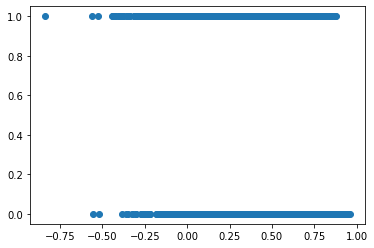

In [0]:
df_copy=getHurst(df_copy)
getStatsForHurst(df_copy)

In [0]:
df_copy_fea=getWaveletFeatures(df_copy,target)

In [0]:
df_copy_fea.head()#our new dataset is ready

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,0.546585,2.601079,-305.176164,-151.216527,723.449162,776.917001,-3.295061,185.214508,421.056252,1.772884e+05,362.384596,-118.255497,-14.756858,112.742925,181.068760,38.918875,43.017619,96.291006,9271.957908,82.299186,-282.140173,-93.356560,83.190719,241.024738,-19.130124,-15.012851,159.427454,25417.113146,127.616292,-84.288361,-27.085687,25.839238,64.083271,-5.246926,-2.354776,46.331585,2146.615760,36.145883,-14.957938,-5.592195,5.819614,13.353548,0.068490,-0.211866,9.135993,83.466361,7.263468,0
1,-0.254452,75.697950,-1242.993850,-488.612159,1410.559480,1774.820173,603.491844,509.288143,1217.249973,1.481697e+06,1139.870482,-1513.818103,-506.059703,178.143757,1402.623818,-40.415845,-140.425072,816.324380,666385.493673,567.598282,-723.611943,-180.580005,125.722567,867.058241,-18.439261,-27.032981,483.947890,234205.560224,313.691461,-230.912721,-40.390111,40.967077,203.621093,0.179625,-1.976516,213.647453,45645.234141,105.978403,-24.898853,-6.318527,4.878626,33.563928,-0.514451,-0.682946,30.317390,919.144152,14.445416,1
2,0.742152,3.615098,-309.103358,-210.090841,-117.128242,-3.579475,-153.466544,-160.911085,93.143353,8.675684e+03,160.911085,-194.163602,-44.434483,2.659560,35.806625,-11.508281,-31.405705,67.695044,4582.618989,44.044606,-110.870327,-48.401351,48.215553,90.924135,5.788707,-0.261057,66.397043,4408.567255,53.872532,-26.976553,-17.167687,16.434903,29.220142,2.497897,0.764631,19.968472,398.739870,17.381640,-7.360370,-3.528846,3.431295,6.996356,-0.295030,-0.251944,4.958808,24.589778,3.869186,0
3,0.767329,12.232493,-392.667105,-384.158663,-274.167936,-168.574097,-295.871642,-294.446636,96.600146,9.331588e+03,295.594845,-50.378062,-6.343640,22.221957,56.380391,8.802419,8.508557,33.808497,1143.014456,26.964985,-49.878219,-17.150750,19.639245,34.120662,7.996985,2.005385,26.269508,690.087074,21.719040,-13.314688,-5.828000,5.282980,14.428778,-0.699589,-0.378611,11.801291,139.270476,8.033911,-5.068773,-2.264661,2.383344,5.377493,0.336105,0.040430,5.218204,27.229656,3.162152,0
4,0.647870,2.538971,-276.585954,-255.283369,5.788142,87.801277,-79.855665,-100.024326,137.229131,1.883183e+04,137.196686,-118.472221,-50.295091,15.728461,61.397235,-13.467008,-16.719396,59.952932,3594.354091,49.218659,-91.214554,-51.554051,31.027079,83.607092,2.235106,-5.263506,53.373437,2848.723725,44.339743,-47.796112,-13.439282,21.991572,49.627529,0.224143,1.325679,29.940156,896.412956,22.968023,-9.831802,-3.274258,3.681270,9.592965,-0.133232,0.179974,7.101117,50.425867,4.900663,0


**Resampling data**

Before the resampling, the 0 class was too prominent.I tried to balance the data by shuffling and resampling the data, In order get a more balanced dataset for machine learning models.

In [0]:
from sklearn.utils import shuffle
def createBalancedDataset(data,random_state):
  #shuffling for random sampling
  X = shuffle(data,random_state=random_state)
  #getting first 6500 value
  return X.sort_values(by=47, ascending=False).iloc[:6500].index

In [0]:
v=createBalancedDataset(df_copy_fea,42)

0    4200
1    2300
Name: 47, dtype: int64

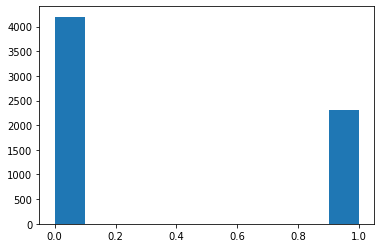

In [0]:
plt.hist((df_copy_fea.iloc[v])[47])
(df_copy_fea.iloc[v][47]).value_counts() #more balanced dataset

**Normalizing Data**

Before the feature selection I normalized data.Normalizing data is necessary for Anova test.Also normalizing is a prerequisite for a lot of machine learning algorithms[11].

In [0]:
#normalizing dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df_copy_fea.drop([47],axis=1))
n_df_fea=pd.DataFrame(scaler.transform(df_copy_fea.drop([47],axis=1)))

**Feature Selection with Anova and Random Forest**

Before giving inputs to models.I inspected whether feature selection improve the accuracies.In order to understand this situation, first i gave all features to model and then i gave only the selected features as input to model and i compared the accuries and f-scores.

For feature selection, I got help by below diagram.Since the dataset's input values are numeric but target variable is categoric, I choosed the Anova test for feature selection.Furthermore i did one more feature selection with random forest in order to compare them together.Eventhough feature selection can be very helpful on improving accuracies in many case, In this situation, it did not help so I decided to continue with all features as input.The process is below.

![alt text](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/11/How-to-Choose-Feature-Selection-Methods-For-Machine-Learning.png)

(picture is taken from [12])


In [0]:
#First the all features are given as a input to SVM model (I will explain why i used SVM later)

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
X_trainr, X_testr, y_trainr, y_testr = train_test_split(n_df_fea.iloc[v], target.iloc[v], test_size=0.33, random_state=42)

In [0]:
#Reference point for svm
from sklearn import svm
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

#I will explain this model in model part in the notebook
clf = svm.SVC(kernel="linear")
clf.fit(X_trainr, y_trainr)
#cross validation is 10
y_pred = cross_val_predict(clf,X_testr,y_testr,cv=10)
print("All features are inclueded\n",classification_report(y_testr, y_pred))

All features are inclueded
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      1373
           1       0.98      0.93      0.95       772

    accuracy                           0.97      2145
   macro avg       0.97      0.96      0.96      2145
weighted avg       0.97      0.97      0.97      2145



**Selecting most important 20 features with Anova**

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
#Selection most important 20 feature by using Anova test
def selectFeature(X_trainr,y_trainr,X_testr):
  sel_f = SelectKBest(f_classif, k=20)
  X_train_f = sel_f.fit_transform(X_trainr, y_trainr)
  mySelectedFeatures=[i for i in range(len(sel_f.get_support())) if sel_f.get_support()[i]==True]
  j=0
  unseable_columns=[]
  #Creating a new dataset with these 20 features
  for i in X_trainr.columns:
    if(j not in mySelectedFeatures):
      unseable_columns.append(i)
    j+=1 
  X_train_arranged=X_trainr.drop(columns=unseable_columns)
  X_test_arranged=X_testr.drop(columns=unseable_columns)
  return  X_train_arranged,X_test_arranged

X_train_arranged,X_test_arranged=selectFeature(X_trainr,y_trainr,X_testr)  

In [0]:
X_train_arranged.columns #The most important columns according to Anova

Int64Index([2, 5, 8, 10, 11, 14, 17, 19, 20, 21, 22, 23, 26, 28, 29, 32, 35,
            37, 44, 46],
           dtype='int64')

In [0]:
#Overall accuracy is decreased
from sklearn import svm
from sklearn.metrics import classification_report
clf = svm.SVC(kernel="linear")
clf.fit(X_train_arranged, y_trainr)
y_pred = cross_val_predict(clf,X_test_arranged,y_testr,cv=10)
print("Only Anova test's Features are used\n",classification_report(y_testr, y_pred))

Only Anova test's Features are used
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1373
           1       0.97      0.92      0.95       772

    accuracy                           0.96      2145
   macro avg       0.96      0.95      0.96      2145
weighted avg       0.96      0.96      0.96      2145



**Selecting most important 20 features with Random Forest**

In [0]:
#Firstly I used grid Search for getting best hyperparameter for random-forest
np.random.seed(42)
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'max_depth': [2,5],
    'min_samples_split':[2,5,10],
    'n_estimators': [100,150],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(X_trainr, y_trainr)
print (CV_rfc.best_params_)

{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 150}


In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42,max_depth=5,max_features='sqrt',min_samples_split=2,n_estimators=150)
clf.fit(X_trainr, y_trainr)
#I also get the importance rates and sort in a desending order and create a dataframe
zipped=pd.DataFrame(zip(X_trainr.columns,clf.feature_importances_),columns=["column","importance"]).sort_values(by="importance", ascending=False)
y_pred2 = cross_val_predict(clf,X_testr,y_testr,cv=10)
print("All featuares are included\n",classification_report(y_testr, y_pred2))

All featuares are included
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1373
           1       0.96      0.96      0.96       772

    accuracy                           0.97      2145
   macro avg       0.97      0.97      0.97      2145
weighted avg       0.97      0.97      0.97      2145



In [0]:
zipped.head(20) #The most important 20 values according to random forest

,column,importance
18,18,0.122870
17,17,0.102400
8,8,0.086825
9,9,0.083827
19,19,0.082742
36,36,0.075209
35,35,0.065976
14,14,0.047009
11,11,0.045067
26,26,0.036911


In [0]:
#F-scores are decreased
clf = svm.SVC(kernel="linear")
clf.fit(X_trainr[zipped.iloc[:20].index], y_trainr)
y_pred = cross_val_predict(clf,X_testr[zipped.iloc[:20].index],y_testr,cv=10)
print("Only random forest's features are inclueded\n",classification_report(y_testr, y_pred))

Only random forest's features are inclueded
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1373
           1       0.96      0.92      0.94       772

    accuracy                           0.96      2145
   macro avg       0.96      0.95      0.96      2145
weighted avg       0.96      0.96      0.96      2145



![alt text](https://drive.google.com/uc?id=1VwWDqamqvC8_W0CHLsWfKYLmhJVmPmKM)

As you can see, The feature selection process did not increase accuracies.Therefore I decided to continue with all features as input


## Modeling<a class="anchor" id="modeling"></a>

In the model selection process, I analysed the most used algoriths in the literature.I encounter that the most used algorithms are ANNs/RNNs, SVMs and Desion Trees.Therefore I decided to use SVM since this task is a binary classification problem , Random Forest for desion trees are pretty popular in the literature and lastly LSTM for RNN's are pretty popular in the literature and it is one of my favorites.

In [0]:
#SVM, for kernel, I used some kernels and get the most accurate one
clf = svm.SVC(kernel="linear",probability=True)
clf.fit(X_trainr, y_trainr)
#cross validation is 10
y_pred = cross_val_predict(clf,X_testr,y_testr,cv=10)
print("All features are included\n",classification_report(y_testr, y_pred))

All features are included
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      1373
           1       0.98      0.93      0.95       772

    accuracy                           0.97      2145
   macro avg       0.97      0.96      0.96      2145
weighted avg       0.97      0.97      0.97      2145



In [0]:
#Random forest, I got hyperparameters from above grid-search
clf1 = RandomForestClassifier(random_state=42,max_depth=5,max_features='auto',min_samples_split=5,n_estimators=150)
clf1.fit(X_trainr, y_trainr)
y_pred2 = cross_val_predict(clf1,X_testr,y_testr,cv=10)
print("All featuares are included\n",classification_report(y_testr, y_pred2))

All featuares are included
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1373
           1       0.96      0.96      0.96       772

    accuracy                           0.97      2145
   macro avg       0.97      0.97      0.97      2145
weighted avg       0.97      0.97      0.97      2145



Using TensorFlow backend.


Train on 4355 samples, validate on 2145 samples
Epoch 1/50
 - 3s - loss: 0.6462 - accuracy: 0.6512 - val_loss: 0.8925 - val_accuracy: 0.6401
Epoch 2/50
 - 2s - loss: 0.5971 - accuracy: 0.7031 - val_loss: 0.6156 - val_accuracy: 0.6606
Epoch 3/50
 - 2s - loss: 0.5679 - accuracy: 0.7504 - val_loss: 0.6364 - val_accuracy: 0.6578
Epoch 4/50
 - 2s - loss: 0.5287 - accuracy: 0.7451 - val_loss: 0.6908 - val_accuracy: 0.6620
Epoch 5/50
 - 2s - loss: 0.5160 - accuracy: 0.7784 - val_loss: 0.6146 - val_accuracy: 0.6834
Epoch 6/50
 - 2s - loss: 0.4950 - accuracy: 0.7713 - val_loss: 0.5547 - val_accuracy: 0.7324
Epoch 7/50
 - 2s - loss: 0.4644 - accuracy: 0.8101 - val_loss: 0.5006 - val_accuracy: 0.7459
Epoch 8/50
 - 2s - loss: 0.4782 - accuracy: 0.8051 - val_loss: 0.4023 - val_accuracy: 0.8191
Epoch 9/50
 - 2s - loss: 0.4100 - accuracy: 0.8439 - val_loss: 0.4037 - val_accuracy: 0.8168
Epoch 10/50
 - 2s - loss: 0.3901 - accuracy: 0.8441 - val_loss: 0.3197 - val_accuracy: 0.8625
Epoch 11/50
 - 2s - l

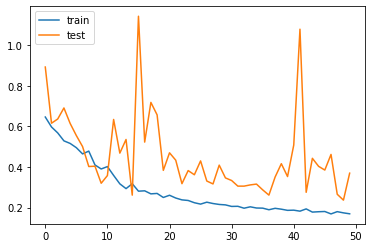

In [0]:
#LSTM
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
# When i designed the network, Basically i used heuristic approach
X_trainrr=np.array(X_trainr).reshape(X_trainr.shape[0],X_trainr.shape[1],1)
X_testrr=np.array(X_testr).reshape(X_testr.shape[0],X_testr.shape[1],1)
model = Sequential()
model.add(LSTM(50, input_shape=(X_trainrr.shape[1], X_trainrr.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
# fit network
history = model.fit(X_trainrr, y_trainr, epochs=50, batch_size=72, validation_data=(X_testrr, y_testr), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Evaluation<a class="anchor" id="evaluation"></a>

For evalaute the model, I used f-scores, ROC curves and overall accuracies.I provided the models accuracies and f-scores as table below.I also provided ROC curves for SVM and Random Forest.

![alt text](https://drive.google.com/uc?id=1Z53mCM5oPJ-yFUI6T1g647KUPrfCTozf)

As you see the most accurate algorithm is Random Forest and all algorithms are more successful at classifiying 0 class than 1 class.

**ROC Curves**

In [0]:
pip install scikit-plot

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


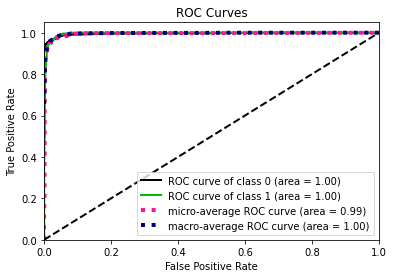

In [0]:
import scikitplot as skplt
import matplotlib.pyplot as plt
#ROC Curve for SVM
y_pred_proba=clf.predict_proba(X_testr)
skplt.metrics.plot_roc_curve(y_testr,y_pred_proba)
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


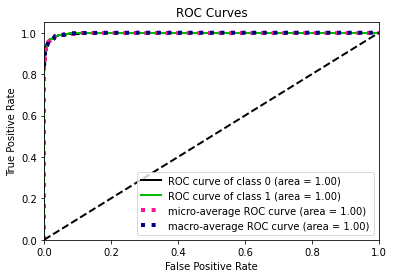

In [0]:
#ROC curve for Random-Forest
y_pred_proba=clf1.predict_proba(X_testr)
skplt.metrics.plot_roc_curve(y_testr,y_pred_proba)
plt.show()

As you can see both models ROC curve areas,f-scores of both classes and overall accuracies are very close to 1 and %100.Therefore the models are very accurate.

## References<a class="anchor" id="references"></a>



$$$$
[1] 	S. A. Hosseini, M-R. Akbarzadeh-T,M-B. Naghibi-Sistani, «Qualitative and Quantitative Evaluation of EEG,» MECS, 2013.

[2] 	Ling Guo, Daniel Rivero, Julián Dorado, Juan R. Rabunal, Alejandro Pazos, «Automatic epileptic seizure detection in EEGs based on line length feature and,» Journal of Neuroscience Methods, 2010. 

[3]Chang BS, Lowenstein DH. Epilepsy. N Engl J Med. 2003;349(13):1257‐1266. doi:10.1056/NEJMra022308

[4]Eadie MJ. Shortcomings in the current treatment of epilepsy. Expert Rev Neurother. 2012;12(12):1419‐1427. doi:10.1586/ern.12.129

[5]D. D. A. ÖZKARDEŞ. [Online]. Available: https://www.memorial.com.tr/saglik-rehberleri/epilepsi-ile-ilgili-bilmeniz-gereken-10-gercek/.

[6]Yuan, Q., Li, F., & Zhong, H. (2015). Early diagnosis, treatment and prognosis of epilepsy with continuous spikes and waves during slow sleep. International journal of clinical and experimental medicine, 8(3), 4052–4058.

[7]«Hurst Exponent,» [Online]. Available: https://en.wikipedia.org/wiki/Hurst_exponent.

[8]«Discrete Wavelet Transform,» [Online]. Available: https://en.wikipedia.org/wiki/Discrete_wavelet_transform.

[9]A. Taşpınar, «A guide for using the Wavelet Transform in Machine Learning,» [Online]. Available: http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/.

[10][Online]. Available: http://ataspinar.com/wp-content/uploads/2018/08/Comparisonoftransformations.jpg.

[11]A. Chavakula. [Online]. Available: https://www.quora.com/Which-machine-algorithms-require-data-scaling-normalization.

[12]J. Brownlee, «Machine Learning Mastery,» [Online]. Available: https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/11/How-to-Choose-Feature-Selection-Methods-For-Machine-Learning.png.

[13]Faust, O., Acharya, U. R., Adeli, H., & Adeli, A. (2015). Wavelet-based EEG processing for computer-aided seizure detection and epilepsy diagnosis. Seizure, 26, 56-64.




**Disclaimer!** <font color='grey'>This notebook was prepared by Nur Altıparmak as a term project for the *BBM469 - Data Intensive Applications Laboratory* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>